In [1]:
import pandas as pd
from tools import get_power, power_to_energy, get_energy, normalize_dataframe,clean_dataframe, get_g5k_password
import matplotlib.pyplot as plt
from statistics import median

password = get_g5k_password()

In [3]:
basename='perc_grisou-6.nancy.grid5000.fr_1585933284'

knowledge = pd.read_csv(basename, sep=' ')
knowledge['fileName'] = knowledge.apply(lambda row: '%s_%s_%s' %(row.hostname, row.fullname, row.startTime), axis=1)
knowledge['basename'] = basename

In [5]:
knowledge['power'] = knowledge.apply(lambda row: median(get_power(row.hostname, row.startTime, row.endTime, password)[1]), axis=1)

In [6]:
def get_load(row, frequency=10, nb_processes=1):
    user_indexes = {'user', 'nice','system','idle','iowait','irq','softirq','steal','guest','guest_nice'}
    filename = row.fileName
    basename = row.basename
    data = clean_dataframe(pd.read_csv(basename+'_mojitos/'+filename,sep=' '))
    return  sum(int(data.median()[name]) for name in user_indexes - {'idle'})/(frequency*nb_processes)

knowledge['load'] = knowledge.apply(lambda row: get_load(row, nb_processes=row.nproc*2), axis=1)

In [7]:
aggregated = knowledge.groupby(['fullname', 'fmax']).mean().reset_index()

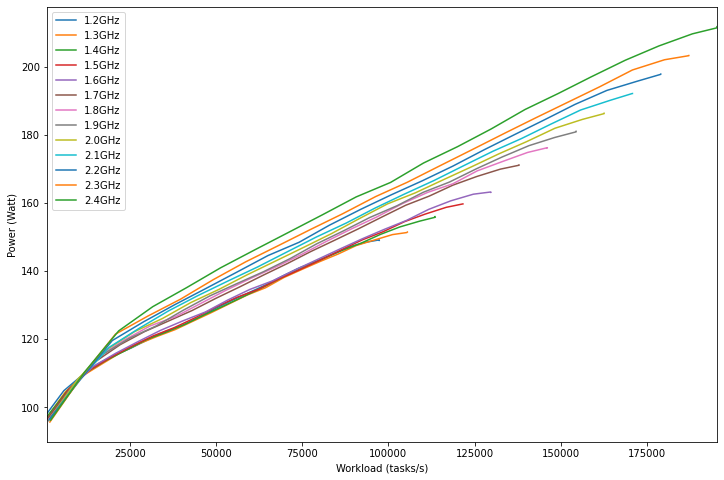

In [8]:
fig, ax = plt.subplots(figsize=(12,8))

for freq in sorted(list(set(knowledge.fmax))):
    per_freq=aggregated[(aggregated.fmax == freq) & (aggregated.duration > 100)]
    per_freq.plot(x='duration',y='power', ax=ax, label='%.1fGHz' % (freq/1000000))

ax.set_ylabel('Power (Watt)')
ax.set_xlabel('Workload (tasks/s)')
    
fig.savefig('power_dvfs_load.pdf',format='pdf', pad_inches=0, bbox_inches='tight')

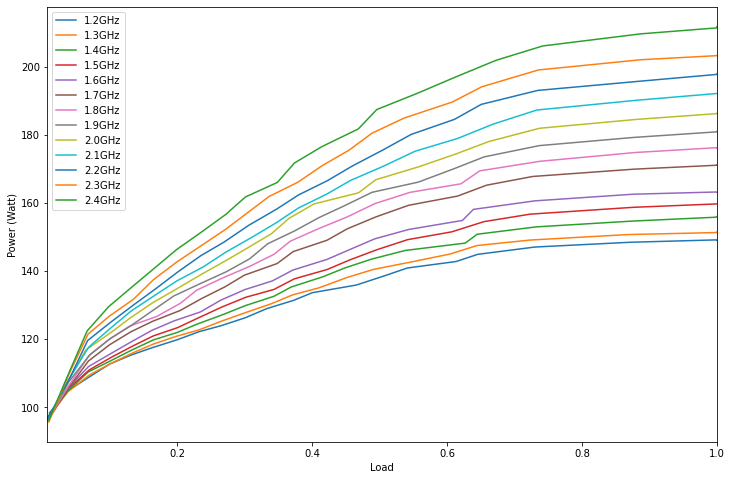

In [9]:
fig, ax = plt.subplots(figsize=(12,8))

for freq in sorted(list(set(knowledge.fmax))):
    per_freq=aggregated[(aggregated.fmax == freq) & (aggregated.duration > 100)]
    per_freq.plot(x='load',y='power', ax=ax, label='%.1fGHz' % (freq/1000000))

ax.set_ylabel('Power (Watt)')
ax.set_xlabel('Load')
    
fig.savefig('power_dvfs_load.pdf',format='pdf', pad_inches=0, bbox_inches='tight')

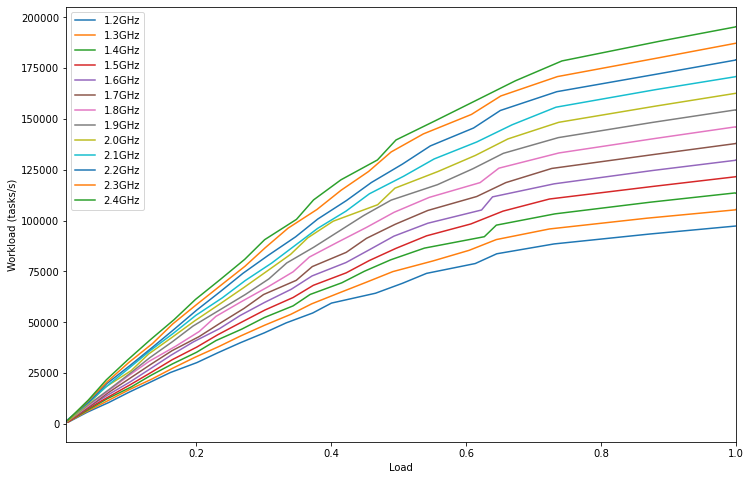

In [10]:
fig, ax = plt.subplots(figsize=(12,8))

for freq in sorted(list(set(aggregated.fmax))):
    per_freq=aggregated[(aggregated.fmax == freq) & (aggregated.duration > 100)]
    per_freq.plot(x='load',y='duration', ax=ax, label='%.1fGHz' % (freq/1000000))

ax.set_ylabel('Workload (tasks/s)')
ax.set_xlabel('Load')
    
fig.savefig('power_dvfs_load.pdf',format='pdf', pad_inches=0, bbox_inches='tight')